# Exploratory Data Analysis

In [6]:
# load and view a .npy file
import numpy as np
from matplotlib import pyplot as plt
import sys
# load the .npy file
initial_inputs = np.load("initial_inputs.npy")
initial_outputs = np.load("initial_outputs.npy")
# summarize shape
print(initial_inputs.shape)
print(initial_outputs.shape)

# create a dataframe from inputs and outputs
import pandas as pd
data = pd.DataFrame(initial_inputs, columns=[f'input_{i}' for i in range(initial_inputs.shape[1])])
data['output'] = initial_outputs
print(data.head())

(10, 2)
(10,)
    input_0   input_1         output
0  0.319404  0.762959   1.322677e-79
1  0.574329  0.879898   1.033078e-46
2  0.731024  0.733000   7.710875e-16
3  0.840353  0.264732  3.341771e-124
4  0.650114  0.681526  -3.606063e-03


## Observations
- Outputs are very small numbers.  Engineering intuition tells me that noise may impact these results signficantly

# Gaussian Process with Upper Confidence Bound Acquisition Function
1. Using the code from Module 12, I get rubbish numbers, but Copilot generated code seems to yeild a better mean, but throws an error re: convergence

In [22]:

import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# parameters from Module 12 - not yet celar on their meaning
rbf_lengthscale = 0.1
noise_assumption = 1e-10


# Load the dataset provided
X = np.load("initial_inputs.npy")
y = np.load("initial_outputs.npy")

# Define the kernel for Gaussian Process - this is generated by Copilot - do not yet understand this properly
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[1.0, 1.0], length_scale_bounds=(1e-2, 1e3))

# Using the kernel creation code from Module 12
#kernel = RBF(length_scale=rbf_lengthscale, length_scale_bounds='fixed')

# Fit Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6, normalize_y=True)
# code from module 12
# gp = GaussianProcessRegressor(kernel=kernel, alpha=noise_assumption)

gp.fit(X, y)


# Define the search space for the next sample (grid in [0,1]x[0,1])
grid_size = 100
x1 = np.linspace(0, 1, grid_size)
x2 = np.linspace(0, 1, grid_size)
X_grid = np.array([[a, b] for a in x1 for b in x2])

# Predict mean and standard deviation for each point in the grid
mean, std = gp.predict(X_grid, return_std=True)

# Upper Confidence Bound (UCB) acquisition function
kappa = 2.0  # Exploration-exploitation trade-off parameter
ucb = mean + kappa * std

# Select the next input sample as the point with the highest UCB
next_index = np.argmax(ucb)
next_sample = X_grid[next_index]

print("Next input sample based on UCB:", next_sample)
print("Predicted mean:", mean[next_index])


Next input sample based on UCB: [0.60606061 0.21212121]
Predicted mean: -0.0002969025713036729


# Gaussian Process with PI Acquisition Function
Using the xi value of 0.01

In [32]:

import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.stats import norm

# Load the dataset provided
X = np.load("initial_inputs.npy")
y = np.load("initial_outputs.npy")

# Define the kernel for Gaussian Process
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[1.0, 1.0], length_scale_bounds=(1e-2, 1e2))

# Fit Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6, normalize_y=True)
gp.fit(X, y)

# Define the search space for the next sample (grid in [0,1]x[0,1])
grid_size = 50
x1 = np.linspace(0, 1, grid_size)
x2 = np.linspace(0, 1, grid_size)
X_grid = np.array([[a, b] for a in x1 for b in x2])

# Predict mean and standard deviation for each point in the grid
mean, std = gp.predict(X_grid, return_std=True)

# Probability of Improvement (PI) acquisition function
best_y = np.max(y)  # For maximisation problem
xi = 0.01  # Small margin for improvement
z = (mean - best_y - xi) / std
pi = norm.cdf(z)

# Select the next input sample as the point with the highest PI
next_index = np.argmax(pi)
next_sample = X_grid[next_index]

print("Next input sample based on PI:", next_sample)
print("Predicted mean:", mean[next_index])
print("Predicted std deviation:", std[next_index])


Next input sample based on PI: [0.04081633 0.40816327]
Predicted mean: -0.00034838978526955647
Predicted std deviation: 0.0010940662603356574


/Users/brucediesel/.pyenv/versions/3.13.3/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


# Gaussian Process with EI Acquisition Function

In [35]:

import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.stats import norm

# Load the dataset provided
X = np.load("initial_inputs.npy")
y = np.load("initial_outputs.npy")

# Define the kernel for Gaussian Process
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[1.0, 1.0], length_scale_bounds=(1e-2, 1e2))

# Fit Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6, normalize_y=True)
gp.fit(X, y)

# Define the search space for the next sample (grid in [0,1]x[0,1])
grid_size = 50
x1 = np.linspace(0, 1, grid_size)
x2 = np.linspace(0, 1, grid_size)
X_grid = np.array([[a, b] for a in x1 for b in x2])

# Predict mean and standard deviation for each point in the grid
mean, std = gp.predict(X_grid, return_std=True)

# Expected Improvement (EI) acquisition function
best_y = np.max(y)  # For maximisation problem
xi = 0.005  # Small margin for improvement
z = (mean - best_y - xi) / std
ei = (mean - best_y - xi) * norm.cdf(z) + std * norm.pdf(z)

# Select the next input sample as the point with the highest EI
next_index = np.argmax(ei)
next_sample = X_grid[next_index]

print("Next input sample based on Expected Improvement (EI):", next_sample)
print("Predicted mean:", mean[next_index])
print("Predicted std deviation:", std[next_index])


Next input sample based on Expected Improvement (EI): [0.44897959 0.14285714]
Predicted mean: -0.0003406260603901083
Predicted std deviation: 0.001093012059247324


/Users/brucediesel/.pyenv/versions/3.13.3/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


# Visualisation

/Users/brucediesel/.pyenv/versions/3.13.3/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


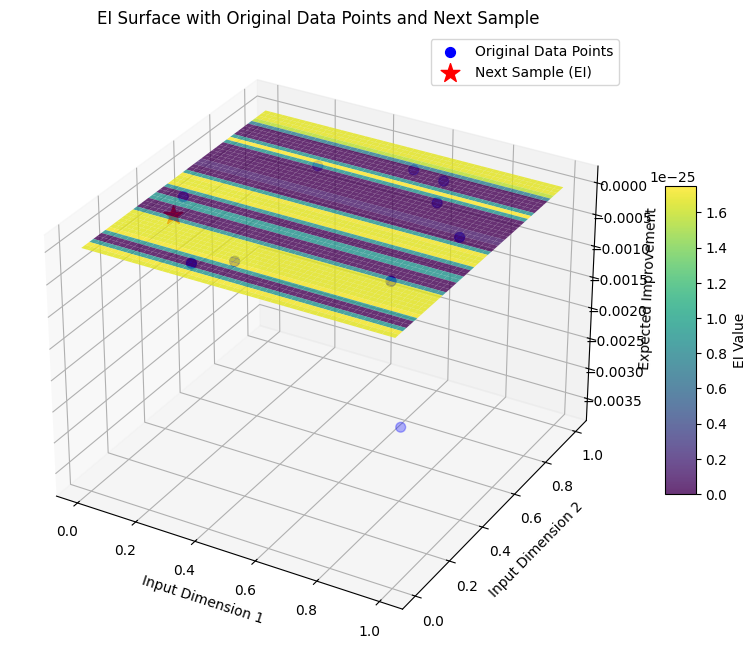

In [36]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.stats import norm

# Example dataset: two input dimensions (X) and one output variable (y)
# Load the dataset provided
X = np.load("initial_inputs.npy")
y = np.load("initial_outputs.npy")

# Define the kernel for Gaussian Process
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[1.0, 1.0], length_scale_bounds=(1e-2, 1e2))

# Fit Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6, normalize_y=True)
gp.fit(X, y)

# Define the search space for the next sample (grid in [0,1]x[0,1])
grid_size = 50
x1 = np.linspace(0, 1, grid_size)
x2 = np.linspace(0, 1, grid_size)
X_grid = np.array([[a, b] for a in x1 for b in x2])

# Predict mean and standard deviation for each point in the grid
mean, std = gp.predict(X_grid, return_std=True)

# Expected Improvement (EI) acquisition function
best_y = np.max(y)  # For maximisation problem
xi = 0.01  # Small margin for improvement
z = (mean - best_y - xi) / std
ei = (mean - best_y - xi) * norm.cdf(z) + std * norm.pdf(z)

# Select the next input sample as the point with the highest EI
next_index = np.argmax(ei)
next_sample = X_grid[next_index]

# Reshape EI for plotting
EI_surface = ei.reshape(grid_size, grid_size)

# Create a 3D plot for EI surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

X1_mesh, X2_mesh = np.meshgrid(x1, x2)

# Plot the EI surface
surf = ax.plot_surface(X1_mesh, X2_mesh, EI_surface, cmap='viridis', alpha=0.8)

# Add original data points (blue circles)
ax.scatter(X[:, 0], X[:, 1], y, color='blue', marker='o', s=50, label='Original Data Points')

# Highlight the selected next point (red star)
ax.scatter(next_sample[0], next_sample[1], mean[next_index], color='red', marker='*', s=200, label='Next Sample (EI)')

# Add labels and title
ax.set_xlabel('Input Dimension 1')
ax.set_ylabel('Input Dimension 2')
ax.set_zlabel('Expected Improvement')
ax.set_title('EI Surface with Original Data Points and Next Sample')

# Add legend and colour bar
ax.legend()
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='EI Value')



# Week 1 Submission
0.448979-0.142857